# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

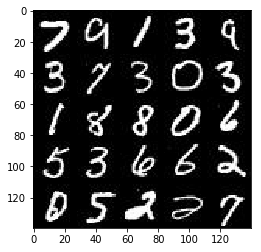

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

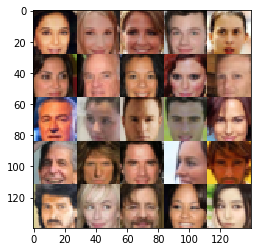

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input_images = tf.placeholder(tf.float32, 
                                       [None, image_width, image_height, image_channels], 
                                       name='real_input_images')
    
    z_data = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    
    
    return real_input_images, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.05):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.03))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        
        
    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.05):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7 

        x2 = tf.layers.conv2d_transpose(x1, 256, 2, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14 

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.truncated_normal_initializer(stddev=0.03))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.03))
        # 28x28xocd 

        out = tf.tanh(logits)
        
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.05):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    samples, losses = [], []
    steps = 0
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Rescale
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z,  input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
            show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

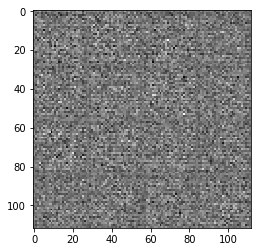

Epoch 1/2... Discriminator Loss: 1.1647... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.5188
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.2994
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 1.2493
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 1.8426
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.5413
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.8409


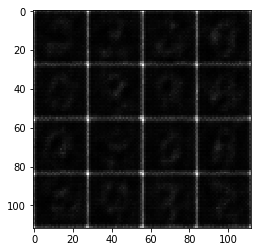

Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 0.4697
Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 1.0252
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 2.0201
Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 2.0253
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 1.0941... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.6813... Generator Loss: 0.3770
Epoch 1/2... Discriminator Loss: 0.8879... Generator Loss: 1.1713


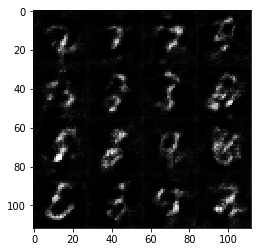

Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 1.4696
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 0.8298
Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 0.9988
Epoch 1/2... Discriminator Loss: 1.0934... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 0.8856... Generator Loss: 1.5156
Epoch 1/2... Discriminator Loss: 1.0081... Generator Loss: 2.5143
Epoch 1/2... Discriminator Loss: 0.9295... Generator Loss: 1.5493
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.9320


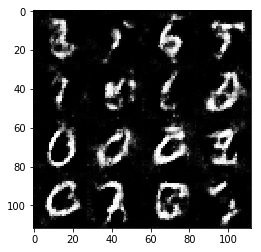

Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 2.6654
Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 1.0835
Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 0.8688
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.6135
Epoch 1/2... Discriminator Loss: 1.0892... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 2.4194
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.1979
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 1.8929
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 0.9269


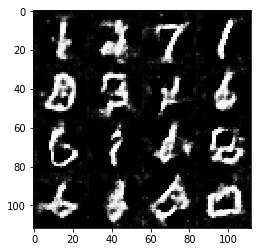

Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 1.6139
Epoch 1/2... Discriminator Loss: 0.9942... Generator Loss: 1.1000
Epoch 1/2... Discriminator Loss: 1.0941... Generator Loss: 1.4296
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 0.8751
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 1.4439
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 1.6799
Epoch 1/2... Discriminator Loss: 0.8754... Generator Loss: 1.2241


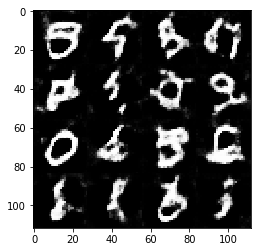

Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 1.0950
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 1.8202
Epoch 1/2... Discriminator Loss: 1.4324... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.0764
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 1.5801... Generator Loss: 0.4347
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 1.1555


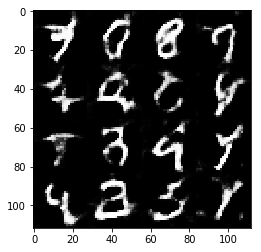

Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.2399
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.2476
Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 1.1543
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.4301
Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 0.9890
Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 0.8403
Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 0.9336... Generator Loss: 1.7316
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 1.0501
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 0.9990


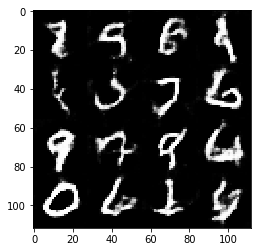

Epoch 1/2... Discriminator Loss: 0.8374... Generator Loss: 1.3761
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 0.9643... Generator Loss: 1.3640
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 1.3376
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 1.8355
Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 0.9362
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 0.9188... Generator Loss: 1.0005
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 0.9618


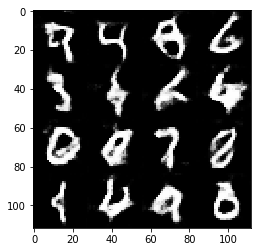

Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 2.2342
Epoch 1/2... Discriminator Loss: 0.9321... Generator Loss: 1.7714
Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 1.1338
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 0.9398
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 0.9522
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 1.8958
Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 1.3805


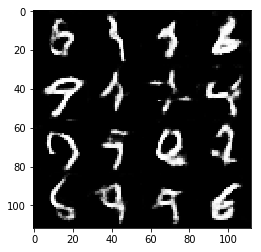

Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 1.8517
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.0639
Epoch 1/2... Discriminator Loss: 0.9675... Generator Loss: 0.9418


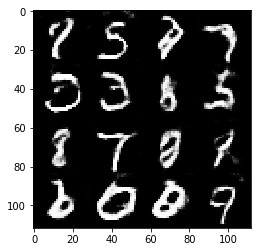

Epoch 2/2... Discriminator Loss: 0.9012... Generator Loss: 1.3419
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.3865
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 2.6402
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 1.7107
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.6772
Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 1.1053
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.2762


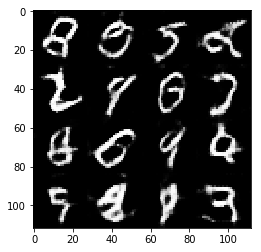

Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.6341
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.2249
Epoch 2/2... Discriminator Loss: 0.8843... Generator Loss: 1.6978
Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.3561
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.8549
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.7125
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 1.4447
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 1.5756... Generator Loss: 0.3940
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.7801


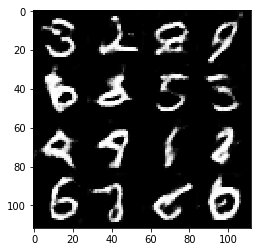

Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 1.3861
Epoch 2/2... Discriminator Loss: 0.8561... Generator Loss: 1.5250
Epoch 2/2... Discriminator Loss: 1.3017... Generator Loss: 1.5531
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.7683
Epoch 2/2... Discriminator Loss: 0.8282... Generator Loss: 1.4776
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 1.3670
Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 0.8874
Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 1.1023
Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 1.8572


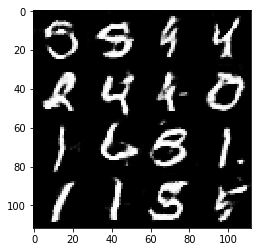

Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.6698
Epoch 2/2... Discriminator Loss: 0.8901... Generator Loss: 1.0562
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.9260
Epoch 2/2... Discriminator Loss: 1.1190... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 0.9933
Epoch 2/2... Discriminator Loss: 0.7227... Generator Loss: 1.8844
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 0.9053
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 1.3678
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.5127
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 0.7997


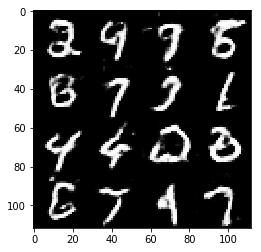

Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.2507
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.3609
Epoch 2/2... Discriminator Loss: 0.8598... Generator Loss: 1.4099
Epoch 2/2... Discriminator Loss: 0.8198... Generator Loss: 1.7033
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 2.3572
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.4957
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.4417
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.2760
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 1.1375


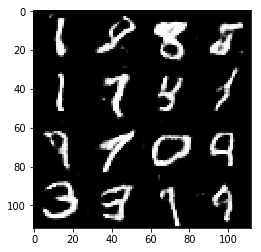

Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.1578
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 2.2081
Epoch 2/2... Discriminator Loss: 0.8041... Generator Loss: 1.7212
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.7341
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.2775
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 2.0682
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 1.5017
Epoch 2/2... Discriminator Loss: 0.9258... Generator Loss: 1.0701
Epoch 2/2... Discriminator Loss: 0.9799... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 1.9038


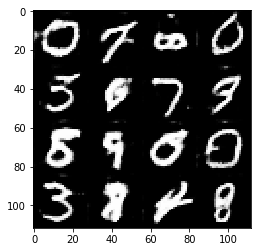

Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 1.5169
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 1.2910
Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.8420
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 1.4502
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 1.2988
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 1.9039
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.2529


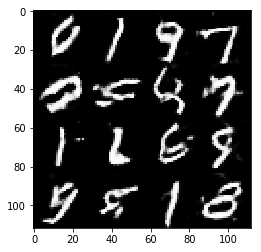

Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 1.7475
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 1.0202
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 1.2591
Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 1.8197
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.4707
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 0.7308... Generator Loss: 1.7368
Epoch 2/2... Discriminator Loss: 0.7953... Generator Loss: 1.4352
Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 1.9939


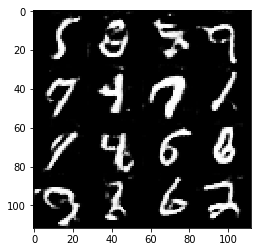

Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.2973
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.7790
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.4201
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 0.9605
Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 1.2390
Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.5583
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.5969
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.1569


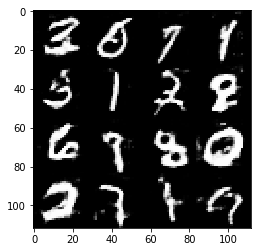

Epoch 2/2... Discriminator Loss: 0.7350... Generator Loss: 1.5954
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 0.9944... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.4630
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 0.9734
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.6755


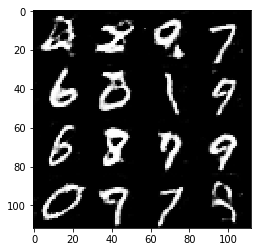

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

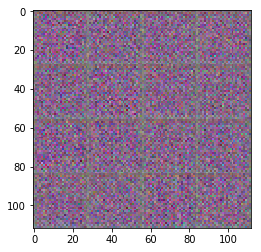

Epoch 1/1... Discriminator Loss: 1.8799... Generator Loss: 0.3054
Epoch 1/1... Discriminator Loss: 2.2057... Generator Loss: 0.2462
Epoch 1/1... Discriminator Loss: 2.2093... Generator Loss: 0.2100
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 3.0780
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.5718
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 1.7721


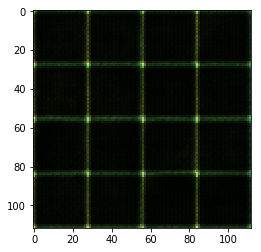

Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.4279
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 2.3643
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 2.5432
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 3.3330
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 2.2630... Generator Loss: 0.1790
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 1.8446
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 6.2270
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 3.6101


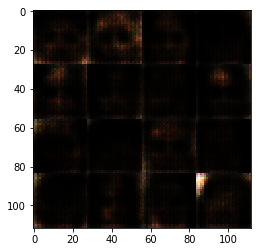

Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 4.4267
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.2652
Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 2.1294
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 3.5804
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 3.4760
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 1.7465
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 2.5224
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 4.4120
Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 2.5232
Epoch 1/1... Discriminator Loss: 0.5885... Generator Loss: 1.7563


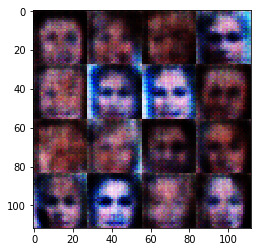

Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 2.9630
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 1.7631
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.8308
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 3.3692
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 2.6131
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 2.1626
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 5.2805
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 2.0283
Epoch 1/1... Discriminator Loss: 0.7253... Generator Loss: 1.3449


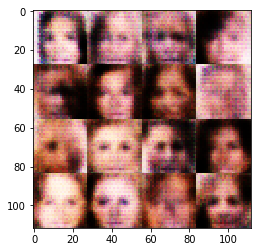

Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 5.5734
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 7.4624
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 2.8810
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 1.9836
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 4.3339
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.4238
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.7582
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 5.0840
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 2.2698


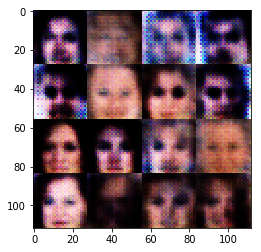

Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 3.4669
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 4.7580
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 3.8570
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 3.6460
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 3.6536
Epoch 1/1... Discriminator Loss: 1.9094... Generator Loss: 0.3321
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 1.4540
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 2.3874
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.4119


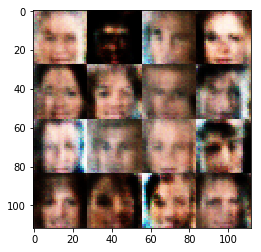

Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 4.5931
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 3.6247
Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 2.8666
Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 2.4690
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 4.7440
Epoch 1/1... Discriminator Loss: 1.7095... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 2.0624... Generator Loss: 0.2186


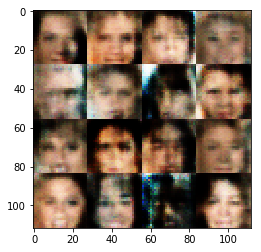

Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.0428
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 1.7147... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 2.0668
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.3679
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 1.4842
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.2880


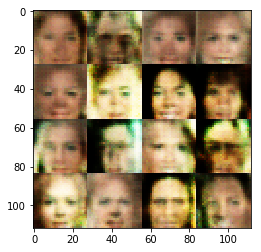

Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 2.0960
Epoch 1/1... Discriminator Loss: 1.7103... Generator Loss: 2.5378
Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.7041
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 3.0364
Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 1.8505
Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 1.5622
Epoch 1/1... Discriminator Loss: 0.5906... Generator Loss: 1.6511


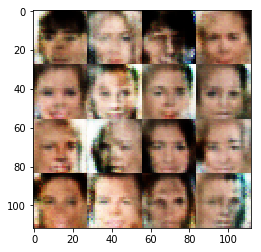

Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 2.1496
Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 2.2343
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 2.3928
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 1.5199
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 2.1837
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.6539
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.4815


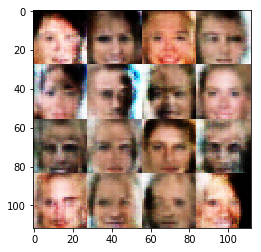

Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 2.5829
Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 5.3206
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 2.2443
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 2.7802
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 2.9654
Epoch 1/1... Discriminator Loss: 0.6376... Generator Loss: 1.5164
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.3727
Epoch 1/1... Discriminator Loss: 2.1365... Generator Loss: 0.2174
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.5113


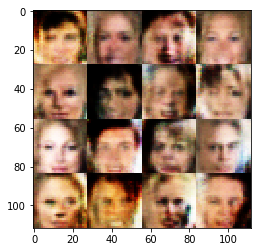

Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 4.0063
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 1.9165... Generator Loss: 0.3022
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 2.7609
Epoch 1/1... Discriminator Loss: 0.4774... Generator Loss: 2.4252
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.4227
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 3.0099
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 2.7426
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.0192


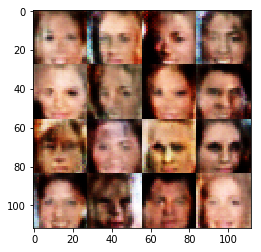

Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 2.2291
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 2.0107
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 0.6783... Generator Loss: 1.5812
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.0153


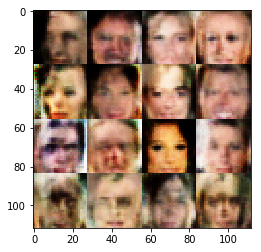

Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.7213
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 2.6225
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 2.3219
Epoch 1/1... Discriminator Loss: 2.5037... Generator Loss: 0.1484
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.3495
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 1.5684
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 2.8815
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 2.8418
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 3.1959


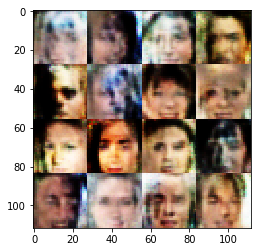

Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 2.9672
Epoch 1/1... Discriminator Loss: 1.8474... Generator Loss: 2.5518
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 2.5396
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 3.0113
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.9854... Generator Loss: 2.8470


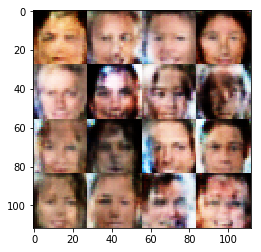

Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 4.9103
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 2.5025
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 4.1633
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 2.0291
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 1.7032
Epoch 1/1... Discriminator Loss: 2.1358... Generator Loss: 0.2118
Epoch 1/1... Discriminator Loss: 1.7245... Generator Loss: 0.3734


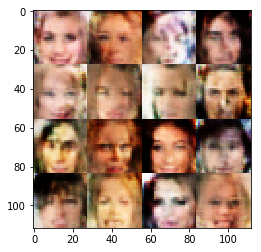

Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 1.8199
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.3621
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.3830
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.1895
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.6890


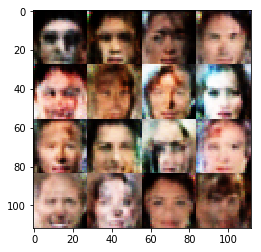

Epoch 1/1... Discriminator Loss: 1.7804... Generator Loss: 0.2971
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.7781
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 1.7813
Epoch 1/1... Discriminator Loss: 1.6684... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 1.9816... Generator Loss: 0.2698
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 2.3142
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.6125


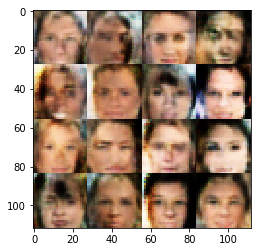

Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 1.7095
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 1.8487
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 4.6627
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 1.6610
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.0969
Epoch 1/1... Discriminator Loss: 2.4552... Generator Loss: 0.1714


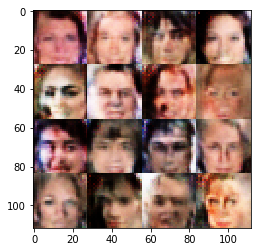

Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 3.2100
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 2.8048
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 2.3194
Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.2913
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.4788
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 2.4415
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.1241


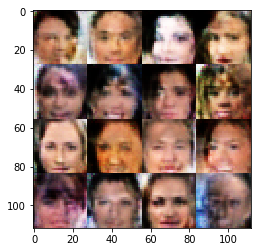

Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 3.8023
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 2.7386
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.1684
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.7504


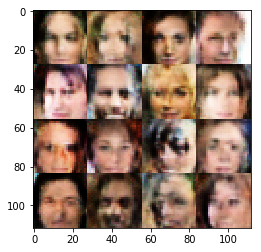

Epoch 1/1... Discriminator Loss: 0.5962... Generator Loss: 3.3804
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.3293
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 2.5996
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.8325


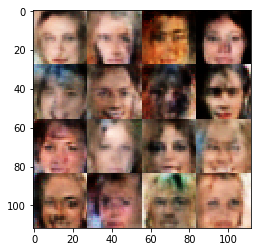

Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.8573... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.5670
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.6072


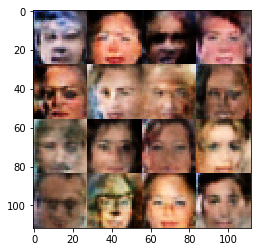

Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.4786
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 0.5701... Generator Loss: 2.4829
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 2.8042
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 3.1393
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 2.1512
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.4925


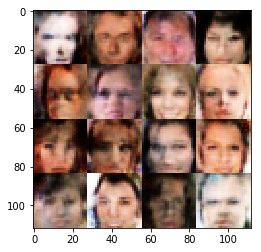

Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.4287
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 2.6179
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.7584
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 1.9236
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 2.1149
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 2.1725


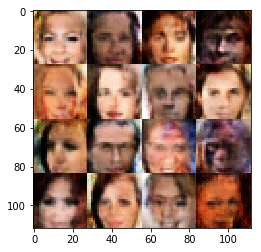

Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 1.9937
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.6668
Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 3.5475
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.6798


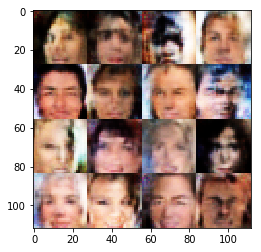

Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 2.2271
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 1.9278
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 2.6871
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.6536
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 3.2619


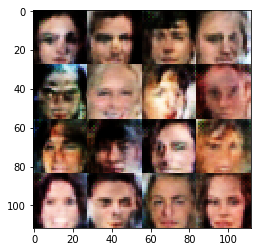

Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 2.2488
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 2.4563
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 3.8978
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 3.1377
Epoch 1/1... Discriminator Loss: 0.4294... Generator Loss: 3.1404


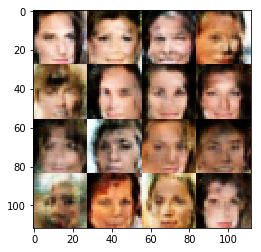

Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.4455
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 2.3019
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 0.4315... Generator Loss: 2.7451


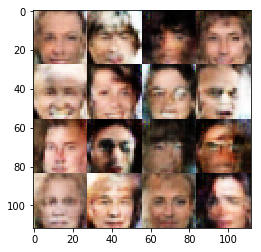

Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.3319
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.3822
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.7487
Epoch 1/1... Discriminator Loss: 2.1562... Generator Loss: 0.2182
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 2.1710
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 2.6947
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.7667
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.8246
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.7430


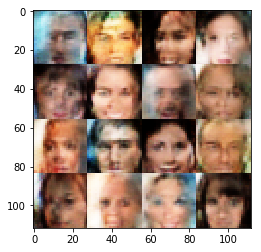

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 1.4422
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.8030
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 2.7160


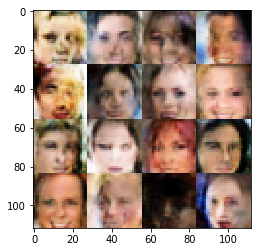

Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 2.4401
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 2.3853
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.5880


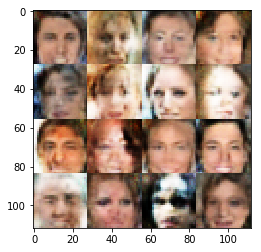

Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 1.7441
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.5548
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.7835


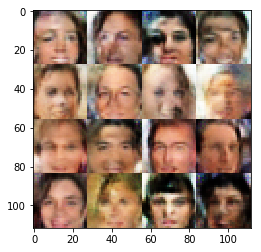

Epoch 1/1... Discriminator Loss: 1.6708... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 1.7982
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.4694
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 2.0032
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.2308


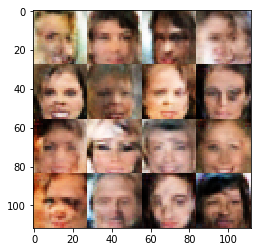

Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 2.7671
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 0.9434


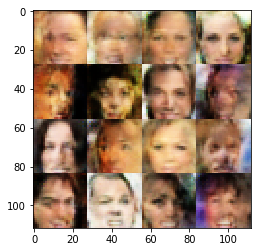

Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 3.1810
Epoch 1/1... Discriminator Loss: 2.1261... Generator Loss: 2.4821
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 1.5605
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.2163
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.9570


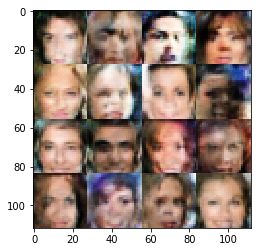

Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 1.3733
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 4.1341
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 2.1469
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.4369
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.4810


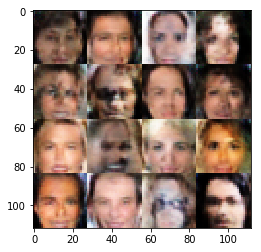

Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 3.3925
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.2417
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.7023
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 3.7683
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 1.7807
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.9010


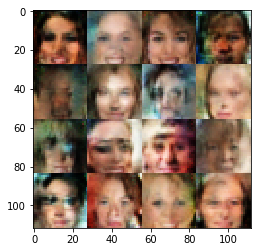

Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 2.1057
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.5947... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 1.9010... Generator Loss: 0.2885
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.4137


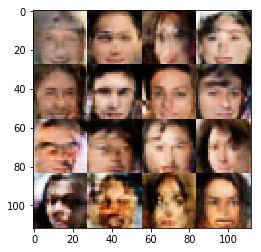

Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.3813
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.8874
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.7085


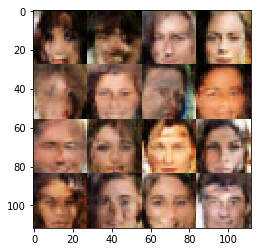

Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.4013
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 2.2342
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.2747


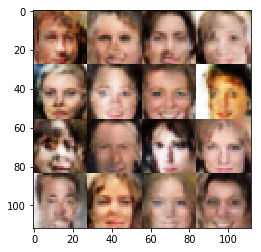

Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 0.7628... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 2.8962
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.8476


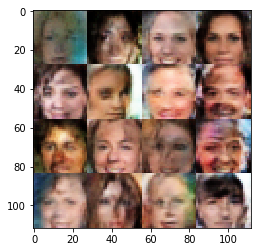

Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.5056
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 2.2580... Generator Loss: 2.6546
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 3.9126


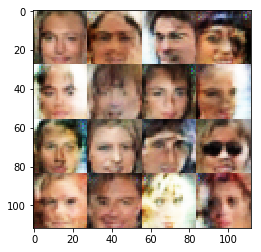

Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 1.5009
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 1.6752... Generator Loss: 0.3343
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.6747


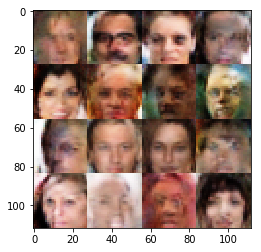

Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 2.2975
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 1.8092
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 0.6504... Generator Loss: 2.1012
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6809


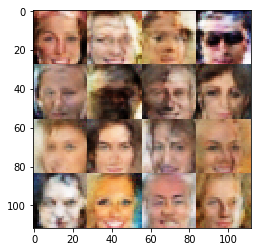

Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 3.0196
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.6642


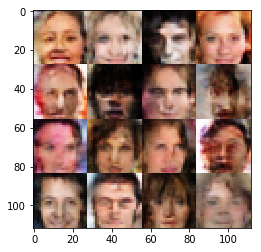

Epoch 1/1... Discriminator Loss: 1.6548... Generator Loss: 0.3669
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.8660
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.0969


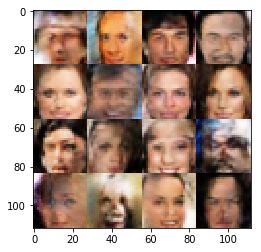

Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.7417
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.6799
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.7643


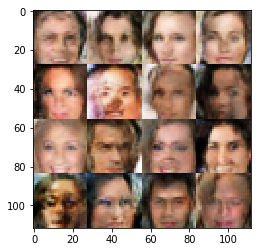

Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.4397
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.5310
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.6919... Generator Loss: 0.3610
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.9140


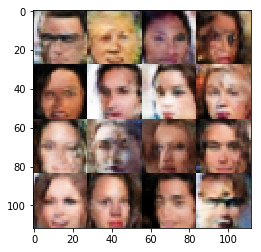

Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.8775... Generator Loss: 0.2758
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.8276... Generator Loss: 1.9377
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 2.1609


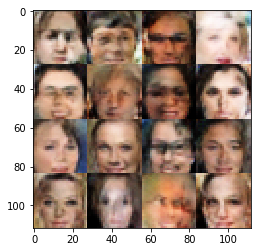

Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 1.7244... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.3797
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.9911


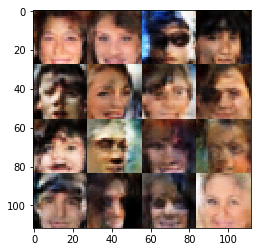

Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.4689
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 1.3556
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.7736... Generator Loss: 0.3268
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 2.8577
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.5205


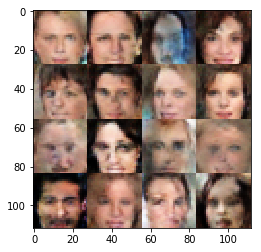

Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.8450... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.6413... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6330


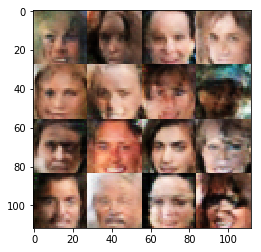

Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 1.7934
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 1.5634
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.3735
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.6975... Generator Loss: 0.3564
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 1.4829


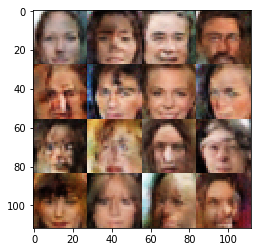

Epoch 1/1... Discriminator Loss: 1.6196... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.5948... Generator Loss: 0.3833
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.9207
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.5603


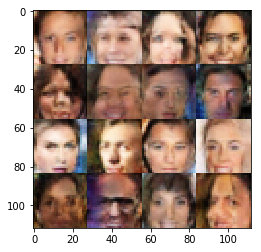

Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.1557


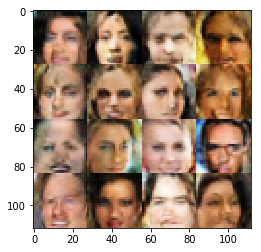

Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 2.0438
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.4729
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7203


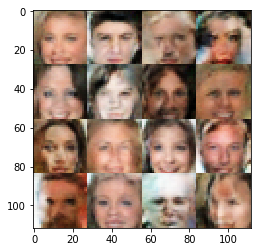

Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 1.2878
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 1.4916
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6025


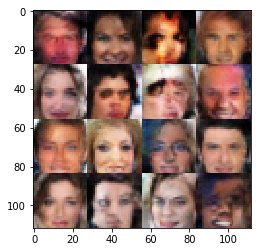

Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.4053
Epoch 1/1... Discriminator Loss: 0.7008... Generator Loss: 2.8251
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 0.5010... Generator Loss: 2.4292
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 3.0895
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.4651


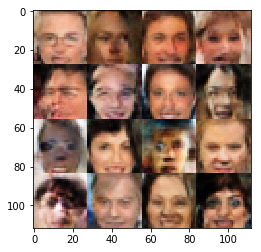

Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 1.8778
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.1978
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.4786


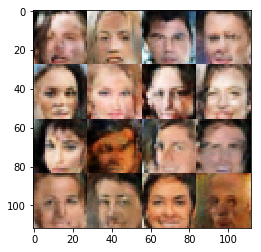

Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.5569
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 2.1330... Generator Loss: 0.2017
Epoch 1/1... Discriminator Loss: 1.7719... Generator Loss: 0.3912
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.3247
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.7249... Generator Loss: 0.3630


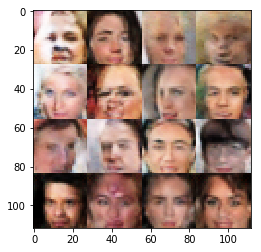

Epoch 1/1... Discriminator Loss: 1.6762... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.3919


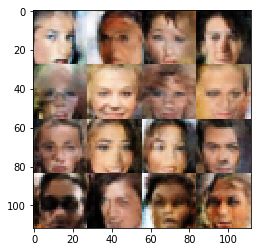

Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.6522... Generator Loss: 0.3733
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.7350... Generator Loss: 0.3638
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6317


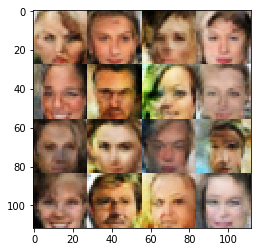

Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.2053
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.5889
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.4597
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.1234
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.6943


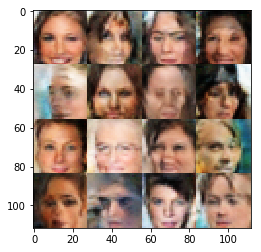

Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 1.6570
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 2.3400... Generator Loss: 0.2332
Epoch 1/1... Discriminator Loss: 1.8662... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.5617


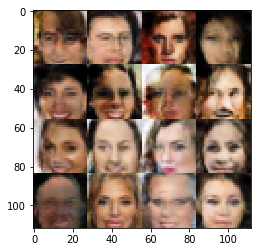

Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.5323


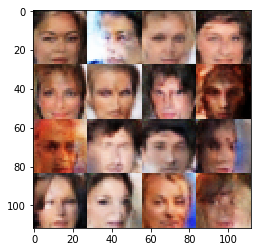

Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.4724
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 2.0792
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.7333


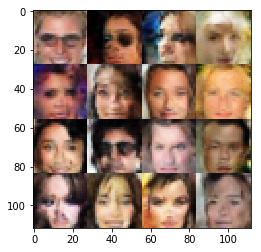

Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.1998
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 3.6786
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 4.5446
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.4714


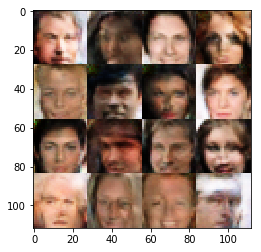

Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.0042


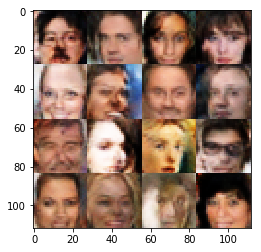

Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.1083


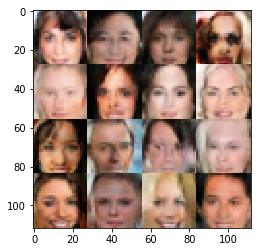

Epoch 1/1... Discriminator Loss: 1.8861... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.8402... Generator Loss: 0.3087
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.1725


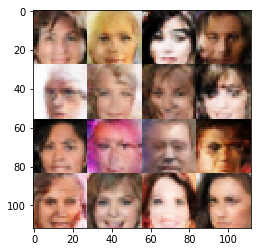

Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 1.4446
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8912


In [ ]:
batch_size = 24
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.